Use TFIDF and Cosine similarity to define high probability scores and low probability scores to define positive and negative matches.  Then use semi-supervised learning to fill in the labels for the remaining matches.  

In [1]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt

porter = nltk.PorterStemmer()

% matplotlib inline
sns.set(style="white", color_codes=True)
stop = stopwords.words('english')
dir = 'C:\\Users\\Travis Park\\Google Drive\\UN\\Team MOZART RAP\\'

In [2]:
tfidfvectorizer =TfidfVectorizer(ngram_range = (1,2),sublinear_tf=False, 
                                 min_df = 0.01, max_features = 1100) 
def TFIDFtotable(inputlist1, inputlist2, newcollist):
    corpus = inputlist1 + inputlist2
    
    x = tfidfvectorizer.fit_transform(corpus)
    x = pd.DataFrame((x * x.T).A)
    
    x = x.ix[:len(inputlist1)-1,len(inputlist1):]
    x.columns = newcollist
    x['Text'] = trimtext
    x = pd.merge(x, Paragraph_DF, how = 'left', left_on = 'Text', right_on = 'StemText')
    x=x.drop(['Text_x','Text_y','TrimText','StemText'],1)
    x=pd.melt(x, id_vars=['Number'])
    x.rename(columns={'Number':'Paragraph','variable': 'Target','value':'T_Cosine'}, inplace = True)
    TFIDFTable = x    
   
    return TFIDFTable

In [3]:
def RemoveVerbs(string):
    if len(string) > 0:
        x = nltk.pos_tag(string.split(' '))
        x = [(word, tag) for (word, tag) in x
             if tag.startswith('N') 
             or tag.startswith('J')
             or tag.startswith('R')]
        x = ' '.join([i[0] for i in x])
        return x
    else:
        return 'x x'

In [4]:
SDG_Targets = pd.read_excel(dir +'SDG_Goals.xlsx', names = ['ID', 'Goal','OrigionalText','GoalText'],sheetname = 'Sheet1')
SDG_Targets['TrimGoal'] = ''

targtext = []
x=0

while x < len(SDG_Targets):
    y = SDG_Targets['GoalText'][x].lower().replace('-',' ').split(' ')
    y = [z for z in y if z.isalpha() if z not in stop]
    targtext.append(' '.join(y))
    x=x+1
    
SDG_Targets['TrimGoal'] = targtext
SDG_Targets['ID'] = SDG_Targets['ID'].astype(int)
SDG_Targets.head(1)

,ID,Goal,OrigionalText,GoalText,TrimGoal
0,1,Poverty,Poverty End poverty in all its forms everywhere,poverty forms eveywhere,poverty forms eveywhere


In [5]:
test = list(SDG_Targets['TrimGoal'])

In [6]:
f = open(dir + 'Bhutan_Doc_test.txt', 'r')
f = f.read().replace('. \n\n','.\n\n').replace('-',' ').replace('\x0c',' ').replace('...','').replace('Eleventh Five Year Plan',' ').split('.\n\n')
f = [w.replace('\n',' ') for w in f]

w=0
wlist=[]
while w<len(f):
    wlist.append(w)
    w=w+1

In [7]:
Paragraph_DF = pd.DataFrame(columns = ['Number','Text', 'TrimText'])
Paragraph_DF['Number'] = wlist
Paragraph_DF['Text'] = f

In [8]:
ttext = []
x = 0 
while x < len(Paragraph_DF):
    y = Paragraph_DF['Text'][x].lower().split(' ')
    y = [z for z in y if z.isalpha() if z not in stop]
    y = RemoveVerbs(' '.join(y))
    ttext.append(y)
    x=x+1
    
Paragraph_DF['TrimText'] = ttext

In [9]:
stemtext = []
x = 0
while x<len(Paragraph_DF):
    y = Paragraph_DF['TrimText'][x].split(' ')
    y = ' '.join([porter.stem(z) for z in y])
    stemtext.append(y)
    x=x+1
    
Paragraph_DF['StemText'] = stemtext

In [10]:
Paragraph_DF.head(1)

,Number,Text,TrimText,StemText
0,0,Main Document Volume I 1 ELEVENTH FIVE ...,main document volume eleventh year plan june m...,main document volum eleventh year plan june ma...


In [11]:
alldocs = ttext+targtext

In [12]:
stuff = "ngram_range = (1,2),sublinear_tf=False, min_df = 0.01, max_features = 1100"
tfidfvectorizer =TfidfVectorizer(ngram_range = (1,2),sublinear_tf=False, 
                                 min_df = 0.01, max_features = 1100) 

x = tfidfvectorizer.fit_transform(alldocs)
y = pd.DataFrame((x * x.T).A)

z = y.ix[:len(ttext)-1,len(ttext):]
z.columns = list(SDG_Targets['ID'])

z1=z.unstack().reset_index()
z1.columns = ['Goal','Paragraph','CosineSimilarity']
z2 = z1[(z1['Goal'] != z1['Paragraph']) & (z1['CosineSimilarity'] > 0)]

z2.sort_values(by = 'CosineSimilarity', ascending = False).head()

avg = z2['CosineSimilarity'].mean()
avg

0.07972625570789885

In [13]:
zx = z.reset_index()
zx.rename(columns={'index': 'paragraph'}, inplace=True)

In [14]:
x1 = pd.DataFrame(x.toarray(),columns = [tfidfvectorizer.get_feature_names()])
x1 = x1.ix[:len(ttext)-1,]
x1 = x1.reset_index()
c = zx.columns 

In [15]:
x1.rename(columns={'level_0': 'paragraph'}, inplace=True)
xx = pd.merge(x1, zx, how = 'left', left_on = 'paragraph', right_on = 'paragraph')

In [51]:
q = xx.ix[:,len(xx.columns)-17:].quantile(q = .95)
print(q)
q = list(q)

1     0.085441
2     0.095492
3     0.132588
4     0.110067
5     0.000000
6     0.103680
7     0.075807
8     0.107786
9     0.091713
10    0.110070
11    0.085386
12    0.087348
13    0.000000
14    0.133220
15    0.065464
16    0.102563
17    0.091642
dtype: float64


In [52]:
i = 0
while i < len(q):
    j = 0
    while j < len(zx):
        #print(zx.ix[j,i+1])
        if zx.ix[j,i+1] >= q[i]:
            zx.ix[j,i+1] = 1
        elif zx.ix[j,i+1] < 0.0000001:
            zx.ix[j,i+1] = 0
        else:
            zx.ix[j,i+1] = -1
        j=j+1
    i=i+1 

In [53]:
X = x1
y = zx.ix[:,6]

In [54]:
set(y)

{0.0, 1.0}

In [55]:
ls = LabelSpreading(kernel='rbf', gamma=20, n_neighbors=20,
                    alpha=0.2, max_iter=50, tol=0.001, n_jobs=-1).fit(X, y)
#ls100 = (label_propagation.LabelSpreading().fit(X, y), y)
#rbf_svc = (svm.SVC(kernel='rbf').fit(X, y), y)
ls.score(X,y)
a = ls.score(X,y)
output_labels = ls.transduction_
set(output_labels)

{0.0, 1.0}

In [56]:
x1['Goal6'] = list(output_labels)

In [59]:
x1[['paragraph','Goal6']].ix[338,]

paragraph    338.0
Goal6          1.0
Name: 338, dtype: float64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, output_labels, test_size=0.50, random_state=42)

In [24]:
###Neural Net
nn = MLPClassifier(solver='adam', activation = 'logistic',
                   hidden_layer_sizes=(50, 10), random_state=1)

nn_pred = nn.fit(X_train,y_train).predict(X_test)
nn.score(X_train,y_train), nn.score(X_test,y_test), nn.score(X_train,y_train)-nn.score(X_test,y_test)

(0.87432675044883301, 0.88888888888888884, -0.014562138440055827)

In [25]:
mtrx = confusion_matrix(y_test,nn_pred)
mtrx

array([[496,   0],
       [ 62,   0]])

In [26]:
gauss = GaussianNB()
gauss_pred = gauss.fit(X_train, y_train).predict(X_test)
gauss.score(X_train,y_train), gauss.score(X_test,y_test), gauss.score(X_train,y_train)-gauss.score(X_test,y_test)

(0.88150807899461403, 0.77060931899641572, 0.11089875999819832)

In [27]:
mtrx = confusion_matrix(y_test,gauss_pred)
mtrx

array([[396, 100],
       [ 28,  34]])

In [28]:
###LogReg
lr = LogisticRegression(penalty = 'l2', dual = True)
lr_pred = lr.fit(X_train, y_train).predict(X_test)
lr.score(X_train,y_train), lr.score(X_test, y_test),lr.score(X_train,y_train)-lr.score(X_test,y_test)

(0.87432675044883301, 0.88888888888888884, -0.014562138440055827)

In [29]:
mtrx = confusion_matrix(y_test,lr_pred)
mtrx

array([[496,   0],
       [ 62,   0]])

In [30]:
###Adaptive Boosting
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=1,learning_rate=1)

ada_pred = ada.fit(X_train,y_train).predict(X_test)
ada.score(X_train,y_train), ada.score(X_test,y_test), ada.score(X_train,y_train)-ada.score(X_test,y_test)

mtrx = confusion_matrix(y_test,ada_pred)
mtrx

array([[465,  31],
       [ 39,  23]])

In [31]:
X.shape

(1115, 972)

In [34]:
j = .1
k1 = len(X.columns)*(.1)
print(k1)
X_new = SelectKBest(chi2, k=k1).fit_transform(X, y)
X_new.shape

X_train, X_test, y_train, y_test = train_test_split(X_new, output_labels, test_size=0.4, random_state=42)

gauss = GaussianNB()
gauss_pred = gauss.fit(X_train, y_train).predict(X_test)
print('gauss -',gauss.score(X_train,y_train), gauss.score(X_test,y_test), gauss.score(X_train,y_train)-gauss.score(X_test,y_test))
print(confusion_matrix(y_test,gauss_pred))

###Adaptive Boosting
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),n_estimators=1,learning_rate=1)
ada_pred = ada.fit(X_train,y_train).predict(X_test)
print('ada -',ada.score(X_train,y_train), ada.score(X_test,y_test), ada.score(X_train,y_train)-ada.score(X_test,y_test))
print(confusion_matrix(y_test,ada_pred))

perc = Perceptron(alpha = 1, penalty = None,fit_intercept = False)
perc_pred = perc.fit(X_train, y_train).predict(X_test)
print('perc -', perc.score(X_train,y_train), perc.score(X_test,y_test), perc.score(X_train,y_train)-perc.score(X_test,y_test))
print(confusion_matrix(y_test,perc_pred))

knn = KNeighborsClassifier(n_neighbors = 2, algorithm = 'auto', weights = 'distance')
knn_pred = knn.fit(X_train, y_train).predict(X_test)
print('knn -',knn.score(X_train,y_train), knn.score(X_test,y_test), knn.score(X_train,y_train)-knn.score(X_test,y_test))
print(confusion_matrix(y_test,knn_pred))

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB(alpha = 4)
bnb_pred = bnb.fit(X_train, y_train).predict(X_test)
print('bnb -',bnb.score(X_train,y_train), bnb.score(X_test,y_test), bnb.score(X_train,y_train)-bnb.score(X_test,y_test))
print(confusion_matrix(y_test,bnb_pred))

97.2
gauss - 0.875934230194 0.860986547085 0.0149476831091
[[348  46]
 [ 16  36]]
ada - 0.925261584454 0.894618834081 0.0306427503737
[[381  13]
 [ 34  18]]
perc - 0.878923766816 0.883408071749 -0.00448430493274
[[394   0]
 [ 52   0]]
knn - 1.0 0.899103139013 0.100896860987
[[376  18]
 [ 27  25]]
bnb - 0.838565022422 0.845291479821 -0.0067264573991
[[361  33]
 [ 36  16]]


C:\Users\Travis Park\Anaconda3_1\lib\site-packages\sklearn\feature_selection\univariate_selection.py:489: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  mask[np.argsort(scores, kind="mergesort")[-self.k:]] = 1


In [51]:
###SVC
svc = SVC(kernel = 'sigmoid',C=10, gamma='auto', probability = True)
svc_pred = svc.fit(X_train, y_train).predict(X_test)
print(svc.score(X_train,y_train), svc.score(X_test, y_test),svc.score(X_train,y_train)-svc.score(X_test,y_test))
confusion_matrix(y_test,svc_pred)

0.834080717489 0.836322869955 -0.00224215246637


array([[357,  37],
       [ 36,  16]])

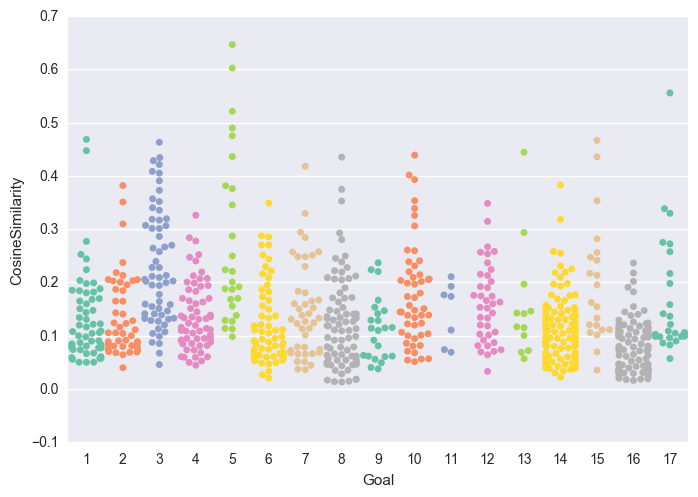

In [31]:
sns.set(style="darkgrid", color_codes=True)
plt = sns.swarmplot(x="Goal", y="CosineSimilarity", data=z4, size = 5, edgecolor = 'w', palette = 'Set2');